## Denoising

Autoencoders can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as the convolutional autoencoder.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


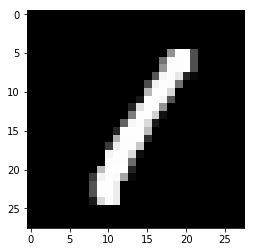

In [3]:
img = mnist.train.images[3]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

In [4]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')
kernel_dimension = 5
pool_dimension = 2
pool_stride = 2

### Encoder
conv1 = tf.layers.conv2d(inputs_,32 ,(kernel_dimension,kernel_dimension),padding='same',activation=tf.nn.relu)
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(conv1,(pool_dimension,pool_dimension),(pool_stride,pool_stride),padding='same')
# Now 14x14x32
conv2 = tf.layers.conv2d(maxpool1,32,(kernel_dimension,kernel_dimension),padding='same',activation=tf.nn.relu)
# Now 14x14x32
maxpool2 =  tf.layers.max_pooling2d(conv2,(pool_dimension,pool_dimension),(pool_stride,pool_stride),padding='same')
# Now 7x7x32
conv3 = tf.layers.conv2d(maxpool2,16,(kernel_dimension,kernel_dimension),padding='same',activation=tf.nn.relu)
# Now 7x7x16
encoded = tf.layers.max_pooling2d(conv3,(pool_dimension,pool_dimension),(pool_stride,pool_stride),padding='same')
# Now 4x4x16

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded,(7,7))
# Now 7x7x16
conv4 = tf.layers.conv2d(upsample1,16,(kernel_dimension,kernel_dimension),padding='same',activation=tf.nn.relu)
# Now 7x7x16
upsample2 = tf.image.resize_nearest_neighbor(conv4,(14,14))
# Now 14x14x16
conv5 = tf.layers.conv2d(upsample2,32,(kernel_dimension,kernel_dimension),padding='same',activation=tf.nn.relu)
# Now 14x14x32
upsample3 = tf.image.resize_nearest_neighbor(conv5,(28,28))
# Now 28x28x32
conv6 = tf.layers.conv2d(upsample3,32,(kernel_dimension,kernel_dimension),padding='same',activation=tf.nn.relu)
# Now 28x28x32

logits = tf.layers.conv2d(conv6,1,(kernel_dimension,kernel_dimension),padding='same',activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=targets_)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [5]:
sess = tf.Session()

In [6]:
epochs = 100
batch_size = 200
step_counter = 0
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        if step_counter%100 == 0:
            print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))
        step_counter+=1

Epoch: 1/100... Training loss: 0.6892
Epoch: 1/100... Training loss: 0.2068
Epoch: 1/100... Training loss: 0.1672
Epoch: 2/100... Training loss: 0.1418
Epoch: 2/100... Training loss: 0.1363
Epoch: 2/100... Training loss: 0.1286
Epoch: 3/100... Training loss: 0.1220
Epoch: 3/100... Training loss: 0.1210
Epoch: 3/100... Training loss: 0.1201
Epoch: 4/100... Training loss: 0.1207
Epoch: 4/100... Training loss: 0.1172
Epoch: 4/100... Training loss: 0.1131
Epoch: 5/100... Training loss: 0.1157
Epoch: 5/100... Training loss: 0.1147
Epoch: 5/100... Training loss: 0.1121
Epoch: 6/100... Training loss: 0.1089
Epoch: 6/100... Training loss: 0.1079
Epoch: 6/100... Training loss: 0.1106
Epoch: 7/100... Training loss: 0.1066
Epoch: 7/100... Training loss: 0.1073
Epoch: 7/100... Training loss: 0.1053
Epoch: 8/100... Training loss: 0.1066
Epoch: 8/100... Training loss: 0.1036
Epoch: 8/100... Training loss: 0.1057
Epoch: 9/100... Training loss: 0.1047
Epoch: 9/100... Training loss: 0.1036
Epoch: 9/100

Epoch: 71/100... Training loss: 0.0934
Epoch: 71/100... Training loss: 0.0931
Epoch: 72/100... Training loss: 0.0933
Epoch: 72/100... Training loss: 0.0934
Epoch: 72/100... Training loss: 0.0925
Epoch: 73/100... Training loss: 0.0913
Epoch: 73/100... Training loss: 0.0910
Epoch: 73/100... Training loss: 0.0909
Epoch: 74/100... Training loss: 0.0922
Epoch: 74/100... Training loss: 0.0942
Epoch: 74/100... Training loss: 0.0932
Epoch: 75/100... Training loss: 0.0923
Epoch: 75/100... Training loss: 0.0909
Epoch: 75/100... Training loss: 0.0909
Epoch: 76/100... Training loss: 0.0923
Epoch: 76/100... Training loss: 0.0917
Epoch: 76/100... Training loss: 0.0952
Epoch: 77/100... Training loss: 0.0929
Epoch: 77/100... Training loss: 0.0917
Epoch: 77/100... Training loss: 0.0921
Epoch: 78/100... Training loss: 0.0906
Epoch: 78/100... Training loss: 0.0901
Epoch: 78/100... Training loss: 0.0927
Epoch: 79/100... Training loss: 0.0919
Epoch: 79/100... Training loss: 0.0908
Epoch: 79/100... Training

## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

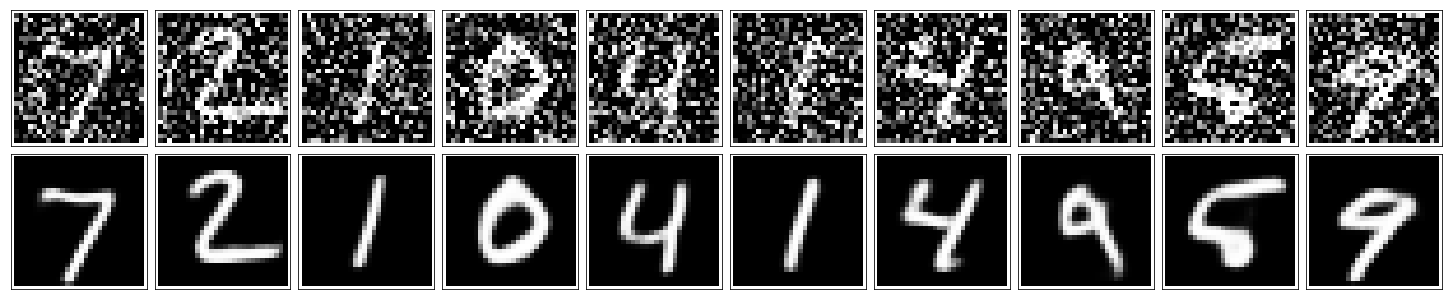

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)